In [22]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

RANDOM_STATE = 42

# ----------------------------
# 1) Load datasets
# ----------------------------
old_df = pd.read_csv("survey_data_cleaned.csv")  # old labeled dataset
new_df = pd.read_csv("StudentsPerformance.csv")  # new unlabeled dataset

target_col = 'Career_Interest'

# Drop unnecessary columns if present
drop_cols = ['Timestamp', 'Date_Of_Birth', 'Age']
old_df = old_df.drop(columns=[c for c in drop_cols if c in old_df.columns])

# ----------------------------
# 2) Map overlapping features
# ----------------------------
feature_mapping = {
    'gender': 'Gender',
    'math score': 'Math',
    'reading score': 'English',
    'writing score': 'English',  # map closest old feature
}
overlapping_features_new = list(feature_mapping.keys())

# ----------------------------
# 3) Encode categorical features
# ----------------------------
def encode_df(df, cat_cols):
    encoders = {}
    df_enc = df.copy()
    for col in cat_cols:
        le = LabelEncoder()
        df_enc[col] = le.fit_transform(df_enc[col].astype(str))
        encoders[col] = le
    return df_enc, encoders

old_overlap_cols = [feature_mapping[f] for f in overlapping_features_new]
cat_cols_old = [c for c in old_overlap_cols if old_df[c].dtype == 'object']
cat_cols_new = [f for f in overlapping_features_new if new_df[f].dtype == 'object']

old_enc_df, old_encoders = encode_df(old_df[old_overlap_cols + [target_col]], cat_cols_old)
new_enc_df, new_encoders = encode_df(new_df[overlapping_features_new], cat_cols_new)


# Encode target
le_target = LabelEncoder()
y_old = le_target.fit_transform(old_enc_df[target_col])
X_old = old_enc_df.drop(columns=[target_col]).values
X_new = new_enc_df.values

# ----------------------------
# 4) Scale features
# ----------------------------
scaler = StandardScaler()
X_old_scaled = scaler.fit_transform(X_old)
X_new_scaled = scaler.transform(X_new)

# ----------------------------
# 5) Train models
# ----------------------------
models = {
    'RF': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE),
    'MLP': MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=RANDOM_STATE),
    'LogReg': LogisticRegression(max_iter=500, random_state=RANDOM_STATE),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE),
    'MMR': LinearRegression()
}

trained = {}
for name, mdl in models.items():
    print(f"[INFO] Training {name} ...")
    mdl.fit(X_old_scaled, y_old)
    trained[name] = mdl

# Ensemble (RF + XGB)
ensemble = VotingClassifier(
    estimators=[('RF', trained['RF']), ('XGB', trained['XGB'])],
    voting='soft'
)
ensemble.fit(X_old_scaled, y_old)
trained['ENSEMBLE'] = ensemble

# ----------------------------
# 6) Predict and create pseudo-labels
# ----------------------------
def predict_model(name, model, X):
    if name == 'MMR':
        y_hat = np.rint(model.predict(X)).astype(int)
        y_hat = np.clip(y_hat, y_old.min(), y_old.max())
        return y_hat
    else:
        return model.predict(X)

# Get predictions from all models
all_preds = {}
for name, mdl in trained.items():
    all_preds[name] = predict_model(name, mdl, X_new_scaled)

# Generate pseudo-labels using majority vote
pseudo_labels = []
for i in range(X_new_scaled.shape[0]):
    votes = [all_preds[m][i] for m in trained if m != 'MMR']  # exclude MMR if you want
    most_common = Counter(votes).most_common(1)[0][0]
    pseudo_labels.append(most_common)

pseudo_labels = np.array(pseudo_labels)

# ----------------------------
# 7) Evaluate models using pseudo-labels
# ----------------------------
for name, mdl in trained.items():
    y_pred = all_preds[name]
    print(f"\n===== {name} (pseudo-evaluation) =====")
    print(classification_report(pseudo_labels, y_pred))
    print("Accuracy:", accuracy_score(pseudo_labels, y_pred))

# Optional: show predicted class distributions
for name, preds in all_preds.items():
    counts = Counter(preds)
    print(f"\n===== {name} predicted class distribution =====")
    total = sum(counts.values())
    for cls, cnt in counts.items():
        print(f"Class {cls}: {cnt} samples ({cnt/total*100:.2f}%)")


[INFO] Training RF ...
[INFO] Training XGB ...
[INFO] Training MLP ...
[INFO] Training LogReg ...
[INFO] Training SVM ...
[INFO] Training MMR ...

===== RF (pseudo-evaluation) =====
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       374
           1       0.88      0.79      0.83       428
           2       0.71      0.75      0.73       114
           3       0.78      0.87      0.82        84

    accuracy                           0.81      1000
   macro avg       0.79      0.81      0.80      1000
weighted avg       0.82      0.81      0.81      1000

Accuracy: 0.812

===== XGB (pseudo-evaluation) =====
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       374
           1       0.79      0.66      0.72       428
           2       0.48      0.73      0.58       114
           3       0.46      0.82      0.59        84

    accuracy                           0.70      1000
   m

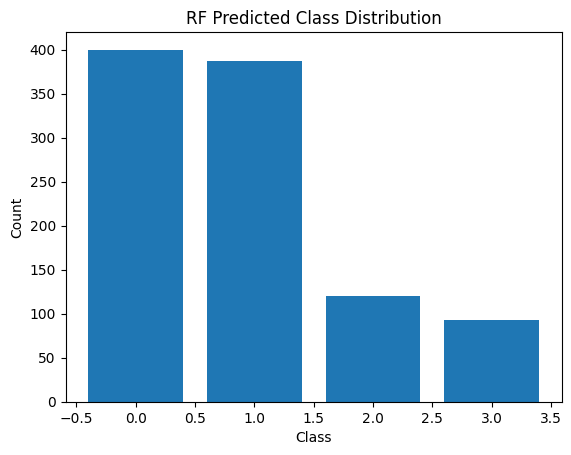

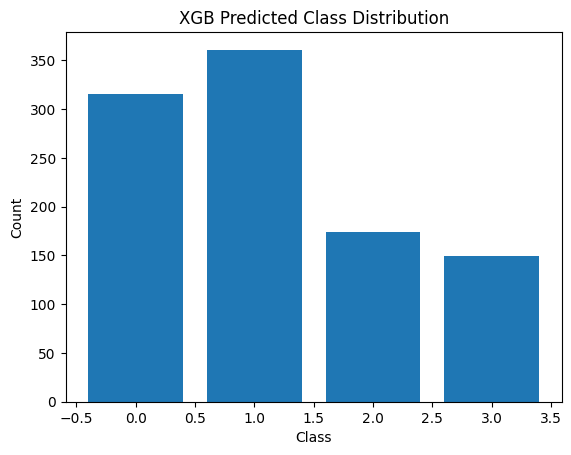

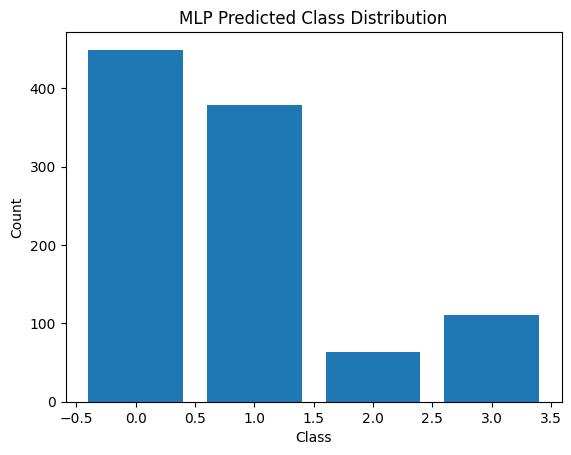

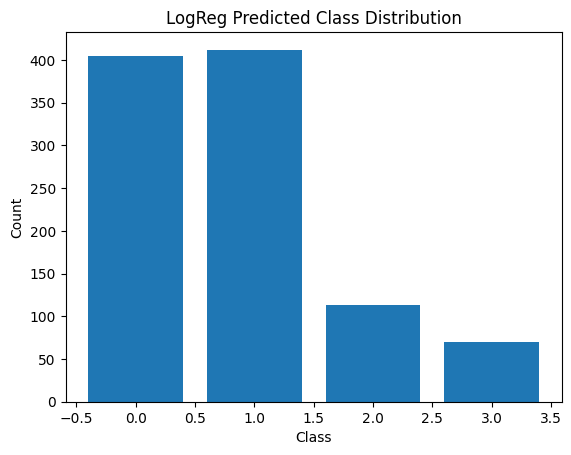

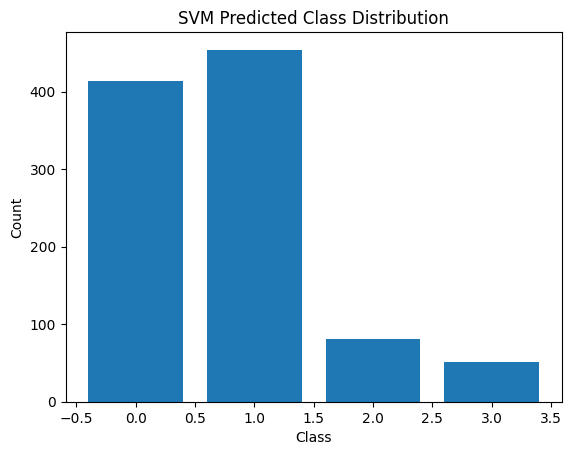

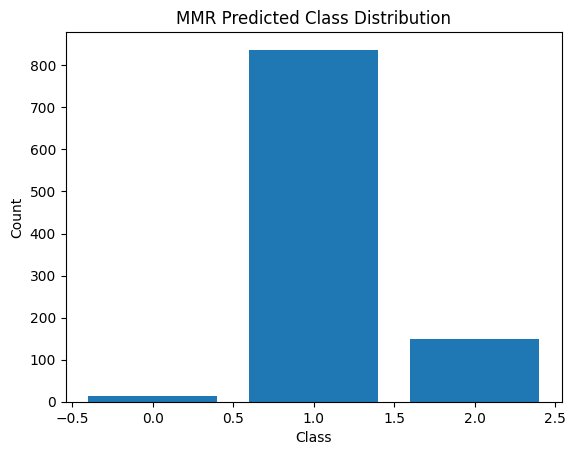

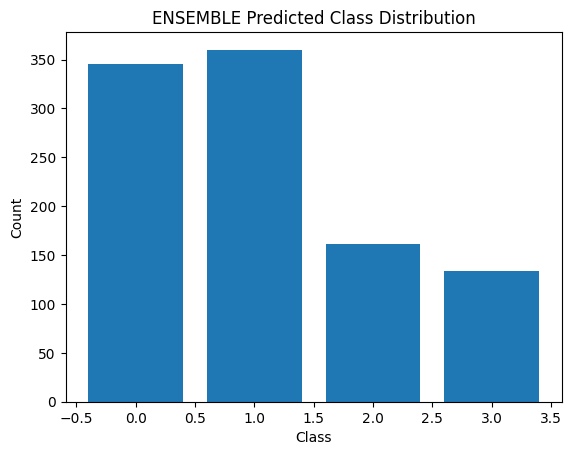

In [21]:
import matplotlib.pyplot as plt
for name, mdl in trained.items():
    y_pred = predict_model(name, mdl, X_new_scaled)
    counts = Counter(y_pred)
    plt.figure()
    plt.bar(counts.keys(), counts.values())
    plt.title(f"{name} Predicted Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()


[INFO] Original dataset class distribution:
Class 0: 25.36%
Class 1: 30.62%
Class 2: 19.62%
Class 3: 24.40%

===== RF Predicted class distribution =====
Class 0: 40.00%
Class 1: 38.70%
Class 2: 12.00%
Class 3: 9.30%

===== XGB Predicted class distribution =====
Class 0: 31.60%
Class 1: 36.10%
Class 2: 17.40%
Class 3: 14.90%

===== MLP Predicted class distribution =====
Class 0: 44.90%
Class 1: 37.80%
Class 2: 6.30%
Class 3: 11.00%

===== LogReg Predicted class distribution =====
Class 0: 40.50%
Class 1: 41.20%
Class 2: 11.30%
Class 3: 7.00%

===== SVM Predicted class distribution =====
Class 0: 41.40%
Class 1: 45.40%
Class 2: 8.10%
Class 3: 5.10%

===== MMR Predicted class distribution =====
Class 0: 1.30%
Class 1: 83.70%
Class 2: 15.00%
Class 3: 0.00%

===== ENSEMBLE Predicted class distribution =====
Class 0: 34.50%
Class 1: 36.00%
Class 2: 16.10%
Class 3: 13.40%


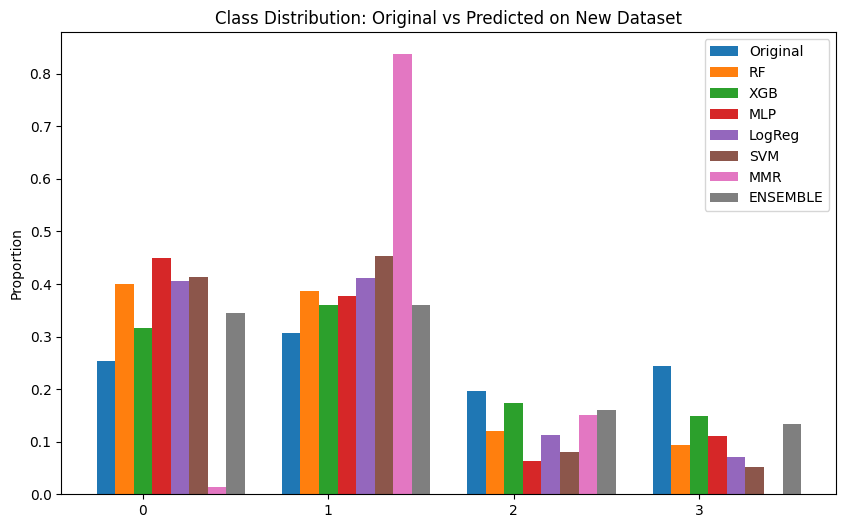

In [26]:
import matplotlib.pyplot as plt
from collections import Counter

# -----------------------------
# Helper function to get class distributions
# -----------------------------
def get_class_distribution(y, class_names=None):
    counter = Counter(y)
    total = sum(counter.values())
    if class_names is None:
        class_names = sorted(counter.keys())
    dist = {cls: counter.get(cls, 0)/total for cls in class_names}
    return dist

# -----------------------------
# Old dataset class distribution
# -----------------------------
y_old_labels = le_target.inverse_transform(y_old)  # original labels
old_dist = get_class_distribution(y_old_labels, class_names=list(le_target.classes_))

print("[INFO] Original dataset class distribution:")
for cls, ratio in old_dist.items():
    print(f"Class {cls}: {ratio*100:.2f}%")

# -----------------------------
# Predicted distributions on new dataset
# -----------------------------
for name, mdl in trained.items():
    y_pred = predict_model(name, mdl, X_new_scaled)
    y_pred_labels = le_target.inverse_transform(y_pred)
    pred_dist = get_class_distribution(y_pred_labels, class_names=list(le_target.classes_))
    
    print(f"\n===== {name} Predicted class distribution =====")
    for cls, ratio in pred_dist.items():
        print(f"Class {cls}: {ratio*100:.2f}%")

# -----------------------------
# Optional: Visual comparison plot
# -----------------------------
plt.figure(figsize=(10,6))
x = range(len(le_target.classes_))
width = 0.1

plt.bar([i - width*2 for i in x], [old_dist[c] for c in le_target.classes_], width, label='Original')

for i, (name, mdl) in enumerate(trained.items()):
    y_pred = predict_model(name, mdl, X_new_scaled)
    y_pred_labels = le_target.inverse_transform(y_pred)
    pred_dist = get_class_distribution(y_pred_labels, class_names=list(le_target.classes_))
    plt.bar([j + width*i - width for j in x], [pred_dist[c] for c in le_target.classes_], width, label=name)

plt.xticks(x, le_target.classes_)
plt.ylabel('Proportion')
plt.title('Class Distribution: Original vs Predicted on New Dataset')
plt.legend()
plt.show()


In [2]:
import os
import joblib

# ----------------------------
# 9) Save trained models
# ----------------------------
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

for name, mdl in trained.items():
    model_path = os.path.join(model_dir, f"{name}_model.pkl")
    joblib.dump(mdl, model_path)
    print(f"[INFO] Saved {name} model to {model_path}")


[INFO] Saved RF model to saved_models/RF_model.pkl
[INFO] Saved XGB model to saved_models/XGB_model.pkl
[INFO] Saved MLP model to saved_models/MLP_model.pkl
[INFO] Saved LogReg model to saved_models/LogReg_model.pkl
[INFO] Saved SVM model to saved_models/SVM_model.pkl
[INFO] Saved MMR model to saved_models/MMR_model.pkl
[INFO] Saved ENSEMBLE model to saved_models/ENSEMBLE_model.pkl


In [3]:
scaler_path = os.path.join(model_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"[INFO] Saved scaler to {scaler_path}")


[INFO] Saved scaler to saved_models/scaler.pkl


In [16]:
import pandas as pd

# Load the dataset
df2 = pd.read_csv("StudentsPerformance.csv")

# Show basic info
print(df2.shape)
print(df2.columns)

# Show first 5 rows
print(df2.head())

# Show data types
print(df2.dtypes)

# Show unique target values if you know the target column name
# Example:
# print(df2['Career_Interest'].value_counts())


(1000, 8)
Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none       

In [7]:
import joblib
import os

model_dir = "saved_models"

# Load all models
models = {
    'RF': joblib.load(os.path.join(model_dir, "RF_model.pkl")),
    'XGB': joblib.load(os.path.join(model_dir, "XGB_model.pkl")),
    'MLP': joblib.load(os.path.join(model_dir, "MLP_model.pkl")),
    'LogReg': joblib.load(os.path.join(model_dir, "LogReg_model.pkl")),
    'SVM': joblib.load(os.path.join(model_dir, "SVM_model.pkl")),
    'MMR': joblib.load(os.path.join(model_dir, "MMR_model.pkl")),
    'ENSEMBLE': joblib.load(os.path.join(model_dir, "ENSEMBLE_model.pkl")),
}

# Load scaler
scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))


In [11]:
import joblib

scaler = joblib.load("saved_models/scaler.pkl")

print("[INFO] Feature names used in model:")
print(list(scaler.feature_names_in_))
print("[INFO] Number of features:", len(scaler.feature_names_in_))


[INFO] Feature names used in model:
['Gender', 'Age_Group', 'Aptitude', 'Parents_Education_Encoded', 'Family_Lifestyle_Encoded', 'Math', 'English', 'Bio', 'Chemistry', 'Physics', 'ICT', 'Business', 'Average_Score', 'if_HS_Student', 'Study_Method', 'Study_Habit', 'English_Proficiency', 'IELTS_Score', 'Favorite_Subject', 'Personality_Trait', 'Address', 'Study_Country', 'Chosen_University', 'Influence', 'Building miniatures / models', 'DIY projects', 'Debate / Public Speaking', 'Hackathons / App development projects', 'Programming / coding clubs', 'Science clubs', 'Student Council / Leadership Roles', 'Volunteering at hospitals, clinics, or NGOs', 'DIY / Project recognition', 'Debate / Public Speaking awards', 'Hackathon / App competition prize', 'Model building recognition', 'Other (please specify)', 'Programming / Coding award', 'Science fair / Olympiad prize', 'Student Council / Leadership role', 'Volunteering recognition']
[INFO] Number of features: 41


1️⃣ Features

You are only using overlapping features between the old dataset (where you trained) and the new dataset (where you test).

Many features from the old dataset are missing in the new dataset, so the models are predicting with incomplete information.

This makes generalization harder, and some class predictions might be biased.

2️⃣ Target / Labels

The new dataset has no target labels, so you cannot calculate true accuracy, precision, recall, or F1.

Any evaluation you do is pseudo-evaluation, i.e., guessing based on the old data distribution or model predictions.

⚠️ Implication

You cannot know for sure if your models are correct on the new dataset.

What you can do is:

Check predicted class distributions (you did that).

Look for extreme skew — if predictions are totally off compared to the old distribution, the model doesn’t generalize well.

Optionally use pseudo-labeling or self-training to iteratively refine predictions.

In [32]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.metrics import accuracy_score, classification_report

# ================================
# 1️⃣ Load Saved Models & Scaler
# ================================
model_dir = "saved_models"

models = {
    "RF": joblib.load(os.path.join(model_dir, "RF_model.pkl")),
    "XGB": joblib.load(os.path.join(model_dir, "XGB_model.pkl")),
    "MLP": joblib.load(os.path.join(model_dir, "MLP_model.pkl")),
    "LogReg": joblib.load(os.path.join(model_dir, "LogReg_model.pkl")),
    "SVM": joblib.load(os.path.join(model_dir, "SVM_model.pkl")),
    "MMR": joblib.load(os.path.join(model_dir, "MMR_model.pkl")),
    "ENSEMBLE": joblib.load(os.path.join(model_dir, "ENSEMBLE_model.pkl")),
}

scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
feature_cols = scaler.feature_names_in_  # columns used during training

# Try to load encoders if available
try:
    encoders = joblib.load(os.path.join(model_dir, "encoders.pkl"))
    print("[INFO] Loaded encoders.")
except:
    encoders = None
    print("[WARNING] No encoders found — fallback encoding will be used.")


# ================================
# 2️⃣ Load New Data
# ================================
df_new = pd.read_csv("myanmar_parent_gen_student_dataset.csv")
target_col = "Career_Interest"

# Separate target if available
if target_col in df_new.columns:
    y_new = df_new[target_col]
else:
    y_new = None

# Drop unused columns
drop_cols = ["Timestamp", "Date_Of_Birth", "Age"]
df_new = df_new.drop(columns=[c for c in drop_cols if c in df_new.columns])


# ================================
# 3️⃣ Encode categorical features
# ================================
def encode_column(col, series):
    """Encode using saved encoder if available, fallback to category codes."""
    if encoders and col in encoders:
        encoder = encoders[col]
        known = set(encoder.classes_)
        series = series.apply(lambda x: x if x in known else list(known)[0])
        return encoder.transform(series)
    else:
        return series.astype("category").cat.codes

df_encoded = df_new.copy()
for col in df_encoded.columns:
    if df_encoded[col].dtype == "object" and col != target_col:
        df_encoded[col] = encode_column(col, df_encoded[col])


# ================================
# 4️⃣ Align features to model
# ================================
X_new = pd.DataFrame()
for col in feature_cols:
    if col in df_encoded.columns:
        X_new[col] = df_encoded[col].fillna(0)
    else:
        X_new[col] = 0

# Enforce column order
X_new = X_new[feature_cols]
print("[INFO] X_new shape:", X_new.shape)  # should match training features


# ================================
# 5️⃣ Scale features
# ================================
X_new_scaled = scaler.transform(X_new)


# ================================
# 6️⃣ Predict & Evaluate
# ================================
def predict_model(name, model, X):
    if name == "MMR":
        y_hat = np.rint(model.predict(X)).astype(int)
        y_hat = np.clip(y_hat, 0, len(np.unique(y_new)) - 1)
        return y_hat
    return model.predict(X)


print("\n==============================")
print("MODEL EVALUATION ON NEW DATA")
print("==============================\n")

results = {}

for name, model in models.items():
    try:
        y_pred = predict_model(name, model, X_new_scaled)

        if y_new is not None:
            acc = accuracy_score(y_new, y_pred)
            results[name] = acc

            print(f"\n----- {name} -----")
            print("Accuracy:", round(acc, 4))
            print(classification_report(y_new, y_pred))
        else:
            results[name] = None
            print(f"\n----- {name} -----")
            print("Predictions:", y_pred[:10], "…")
    except Exception as e:
        print(f"[ERROR] {name} failed: {e}")


# ================================
# 7️⃣ Summary of Accuracy
# ================================
if y_new is not None:
    print("\n==============================")
    print("SUMMARY OF MODEL ACCURACY")
    print("==============================")
    for name, acc in results.items():
        print(f"{name}: {acc:.4f}")


[WARNING] No encoders found — fallback encoding will be used.
[INFO] X_new shape: (200, 41)

MODEL EVALUATION ON NEW DATA

[ERROR] RF failed: X has 41 features, but RandomForestClassifier is expecting 29 features as input.
[ERROR] XGB failed: Feature shape mismatch, expected: 29, got 41
[ERROR] MLP failed: X has 41 features, but MLPClassifier is expecting 29 features as input.
[ERROR] LogReg failed: X has 41 features, but LogisticRegression is expecting 29 features as input.
[ERROR] SVM failed: X has 41 features, but SVC is expecting 29 features as input.
[ERROR] MMR failed: X has 41 features, but LinearRegression is expecting 29 features as input.
[ERROR] ENSEMBLE failed: X has 41 features, but RandomForestClassifier is expecting 29 features as input.

SUMMARY OF MODEL ACCURACY


In [101]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder

# ----------------------------
# 1️⃣ Load models, scaler, encoders
# ----------------------------
models = {name: joblib.load(f"saved_models/{name}_model.pkl") for name in 
          ['RF','XGB','MLP','LogReg','SVM','MMR','ENSEMBLE']}
scaler = joblib.load("saved_models/scaler.pkl")
encoders = joblib.load("saved_models/feature_encoders.pkl")

# ----------------------------
# 2️⃣ Define the 28 features to use
# ----------------------------
scaler_features = [
    'Gender', 'Age_Group', 'Aptitude', 'Family_Lifestyle_Encoded', 'Math', 'English', 'Bio', 'Chemistry', 
    'Physics', 'Business', 'Average_Score', 'if_HS_Student', 'Study_Method', 'English_Proficiency', 
    'Favorite_Subject', 'Address', 'Building miniatures / models', 'Hackathons / App development projects', 
    'Programming / coding clubs', 'Science clubs', 'Student Council / Leadership Roles', 
    'Volunteering at hospitals, clinics, or NGOs', 'DIY / Project recognition', 'Debate / Public Speaking awards', 
    'Model building recognition', 'Other (please specify)', 'Programming / Coding award', 'Volunteering recognition'
]

# ----------------------------
# 3️⃣ Load new data
# ----------------------------
df_new = pd.read_csv("myanmar_parent_gen_student_dataset.csv")
target_col = 'Career_Interest'
y_new = df_new[target_col] if target_col in df_new.columns else None
X_new = df_new.drop(columns=[target_col]) if target_col in df_new.columns else df_new.copy()

# ----------------------------
# 4️⃣ Ensure all features exist in new data
# ----------------------------
for col in scaler_features:
    if col not in X_new.columns:
        X_new[col] = 0  # numeric default for missing features

# Keep only the selected features in correct order
X_new = X_new[scaler_features]

# ----------------------------
# 5️⃣ Encode categorical features using saved encoders
# ----------------------------
for col in X_new.columns:
    if col in encoders:
        X_new[col] = X_new[col].astype(str).map(
            lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1
        )
    else:
        if X_new[col].dtype == 'object':
            X_new[col] = LabelEncoder().fit_transform(X_new[col].astype(str))

# Convert all to float before scaling
X_new = X_new.astype(float)

# ----------------------------
# 6️⃣ Scale features
# ----------------------------
X_new_scaled = scaler.transform(X_new)

# ----------------------------
# 7️⃣ Predict safely
# ----------------------------
def safe_predict(name, model, X_df):
    try:
        if name == 'MMR':
            y_hat = np.rint(model.predict(X_df)).astype(int)
            return y_hat
        return model.predict(X_df)
    except Exception as e:
        print(f"[ERROR] {name} prediction failed: {e}")
        return None

# ----------------------------
# 8️⃣ Run predictions
# ----------------------------
for name, mdl in models.items():
    print(f"\n===== {name} =====")
    y_pred = safe_predict(name, mdl, X_new_scaled)
    if y_pred is not None:
        print("Predictions (first 10):", y_pred[:10])


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Chosen_University
- DIY projects
- IELTS_Score


In [97]:
import joblib

# Load scaler, encoders, and feature lists
scaler = joblib.load("saved_models/scaler.pkl")
encoders = joblib.load("saved_models/feature_encoders.pkl")
scaler_features = joblib.load("saved_models/anova_features.pkl")  # 31 features

# ----------------------------
# 1️⃣ Scaler features & stats
# ----------------------------
print(f"[INFO] Scaler was trained on {len(scaler_features)} features:")
print(scaler_features)
print("\nScaler mean:", scaler.mean_)
print("Scaler scale:", scaler.scale_)

# ----------------------------
# 2️⃣ Encoders info
# ----------------------------
print(f"\n[INFO] Number of categorical encoders: {len(encoders)}")
for col, le in encoders.items():
    print(f"Column: {col}, classes: {list(le.classes_)}")

# ----------------------------
# 3️⃣ Features used for ANOVA selection
# ----------------------------
print(f"\n[INFO] ANOVA features (used for training models): {len(scaler_features)}")
print(scaler_features)


[INFO] Scaler was trained on 28 features:
['Gender', 'Age_Group', 'Aptitude', 'Family_Lifestyle_Encoded', 'Math', 'English', 'Bio', 'Chemistry', 'Physics', 'Business', 'Average_Score', 'if_HS_Student', 'Study_Method', 'English_Proficiency', 'Favorite_Subject', 'Address', 'Building miniatures / models', 'Hackathons / App development projects', 'Programming / coding clubs', 'Science clubs', 'Student Council / Leadership Roles', 'Volunteering at hospitals, clinics, or NGOs', 'DIY / Project recognition', 'Debate / Public Speaking awards', 'Model building recognition', 'Other (please specify)', 'Programming / Coding award', 'Volunteering recognition']

Scaler mean: [4.30198491e-01 1.05716437e+00 2.04125165e+00 1.38623141e+00
 7.94872958e+01 7.56754712e+01 4.88505403e+01 5.95245484e+01
 6.57754063e+01 3.17170743e+01 7.85737408e+01 6.74251064e-01
 1.22131973e+00 1.47741873e+00 2.23273325e+00 3.43448693e+00
 2.95395126e+01 7.04798910e+01 2.05694387e-01 3.66172550e-01
 9.37912982e-02 2.08230545

In [42]:
import joblib

scaler = joblib.load("saved_models/scaler_selected.pkl")

print("Number of features scaler was fitted on:", scaler.n_features_in_)
print("Feature means shape:", scaler.mean_.shape)
print("Feature variances shape:", scaler.var_.shape)


Number of features scaler was fitted on: 12
Feature means shape: (12,)
Feature variances shape: (12,)


In [74]:
import pandas as pd

# Load dataset
df_new = pd.read_csv("myanmar_parent_gen_student_dataset.csv")

# 1️⃣ Basic info
print("[INFO] Dataset shape:", df_new.shape)
print("[INFO] Columns:", df_new.columns.tolist())
print("\n[INFO] Data types:\n", df_new.dtypes)

# 2️⃣ Missing values
print("\n[INFO] Missing values per column:\n", df_new.isna().sum())

# 3️⃣ Basic statistics for numeric columns
print("\n[INFO] Numeric columns summary:\n", df_new.describe())

# 4️⃣ Unique values for categorical/object columns
cat_cols = df_new.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    print(f"\n[INFO] Column '{col}' unique values ({df_new[col].nunique()}):")
    print(df_new[col].value_counts(dropna=False))


[INFO] Dataset shape: (200, 45)
[INFO] Columns: ['Timestamp', 'Gender', 'Date_Of_Birth', 'Age', 'Age_Group', 'Aptitude', 'Parents_Education_Encoded', 'Family_Lifestyle_Encoded', 'Math', 'English', 'Bio', 'Chemistry', 'Physics', 'ICT', 'Business', 'Average_Score', 'if_HS_Student', 'Study_Method', 'Study_Habit', 'English_Proficiency', 'IELTS_Score', 'Favorite_Subject', 'Career_Interest', 'Personality_Trait', 'Address', 'Study_Country', 'Chosen_University', 'Influence', 'Building miniatures / models', 'DIY projects', 'Debate / Public Speaking', 'Hackathons / App development projects', 'Programming / coding clubs', 'Science clubs', 'Student Council / Leadership Roles', 'Volunteering at hospitals, clinics, or NGOs', 'DIY / Project recognition', 'Debate / Public Speaking awards', 'Hackathon / App competition prize', 'Model building recognition', 'Other (please specify)', 'Programming / Coding award', 'Science fair / Olympiad prize', 'Student Council / Leadership role', 'Volunteering recognit